In [1]:
# Import libraries

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

import prepare, model

In [2]:
# Load train, target and test datasets

X_train = pd.read_csv('train_features.csv', index_col=0)
Y_train = pd.read_csv('train_targets_scored.csv', index_col=0)
X_test = pd.read_csv('test_features.csv', index_col=0)

# Print their shapes
X_train.shape, Y_train.shape, X_test.shape # Correct

((23814, 875), (23814, 206), (3982, 875))

In [3]:
# Take the top 5 labels from Y_train

y_train = Y_train.loc[:, 'nfkb_inhibitor']

# Print the size of y_train
print(y_train.size)

# Take a peek at y_train
y_train[:5]

23814


sig_id
id_000644bb2    0
id_000779bfc    0
id_000a6266a    0
id_0015fd391    0
id_001626bd3    0
Name: nfkb_inhibitor, dtype: int64

In [4]:
# Concat y_train to X_train to create a new dataframe

df = pd.concat([X_train, y_train], axis=1)

# Print the shape
print(df.shape)

# Take a peek at the dataframe
df.head() # Success

(23814, 876)


,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,nfkb_inhibitor
sig_id,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,0
id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,0
id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,0
id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,0
id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,0


### Preprocess

In [5]:
# Drop the categorical variables

df.drop(columns=['cp_type', 'cp_time', 'cp_dose'], inplace=True)
df.shape # 872 features left + 1 target

(23814, 873)

In [6]:
# Split the data into train/validate/test
train, validate, test = prepare.split_stratify_my_data(df, 'nfkb_inhibitor')

# Print their shapes
train.shape, validate.shape, test.shape

((17145, 873), (4287, 873), (2382, 873))

In [7]:
# Seperate features and target on train

X_train = train.drop(columns='nfkb_inhibitor')
y_train = train.loc[:, 'nfkb_inhibitor']

# Print their shapes
X_train.shape, y_train.shape

((17145, 872), (17145,))

In [8]:
# Seperate features and target on valvalidate

X_validate = validate.drop(columns='nfkb_inhibitor')
y_validate = validate.loc[:, 'nfkb_inhibitor']

# Print their shapes
X_validate.shape, y_validate.shape

((4287, 872), (4287,))

In [9]:
# Seperate features and target on test

X_test = test.drop(columns='nfkb_inhibitor')
y_test = test.loc[:, 'nfkb_inhibitor']

# Print their shapes
X_test.shape, y_test.shape

((2382, 872), (2382,))

In [10]:
# Scale the datasets by StandardScaler

cols_to_scale = X_train.columns.to_list() # all the columns in X need to be scaled

scaler, X_train_scaled, X_validate_scaled, X_test_scaled = prepare.scale_standard(X_train, 
                                                                                  X_validate, 
                                                                                  X_test, 
                                                                                  cols_to_scale)

# Print their shapes
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((17145, 872), (4287, 872), (2382, 872))

In [11]:
# Print the scaler
scaler

StandardScaler()

In [12]:
# Take a peek at scaled features
X_train_scaled.head()

,g-0_scaled,g-1_scaled,g-2_scaled,g-3_scaled,g-4_scaled,g-5_scaled,g-6_scaled,g-7_scaled,g-8_scaled,g-9_scaled,...,c-90_scaled,c-91_scaled,c-92_scaled,c-93_scaled,c-94_scaled,c-95_scaled,c-96_scaled,c-97_scaled,c-98_scaled,c-99_scaled
sig_id,,,,,,,,,,,,,,,,,,,,,
id_53c3ae622,-0.106780,-0.951161,-1.600555,-1.595222,0.715426,0.332126,0.633957,-0.086767,0.658333,-0.467062,...,0.587150,0.267288,0.052992,0.648329,0.359252,0.276642,0.365239,0.385620,0.536313,0.192199
id_e58576cb3,-0.016276,-0.000530,0.263620,-1.473339,-0.778290,-0.173609,-0.341341,-0.148842,-0.181802,-0.183842,...,0.380311,0.592192,0.643760,0.270242,0.317048,0.196930,0.466016,-0.262365,0.346414,0.013010
id_67b0c958a,0.182802,-1.219048,-0.276546,0.281252,0.608324,0.442362,-0.610666,-1.218068,0.019477,-0.638092,...,0.815148,-0.188877,0.977094,-1.598937,0.465435,-0.392448,0.888695,0.935568,-0.272061,-0.408965
id_1c1d59613,-0.099537,-0.157330,0.284396,0.563249,-1.753332,-0.306693,-0.522420,-1.199525,0.851969,0.772061,...,0.335649,0.351500,0.010460,0.432502,0.149295,-0.435615,0.546588,0.229627,-0.234593,1.179543
id_93905b6e8,-1.182350,-1.053523,-0.886612,1.999799,-1.251202,-0.364155,-0.492110,-0.342219,1.004825,0.690344,...,0.428515,0.550799,0.750887,1.155468,0.426844,0.353656,0.581957,0.712796,0.222861,1.369131


In [13]:
# Check the variance of the scaled features
X_train_scaled.var(axis=0) # Checked: should be 1 from begining to the end

g-0_scaled     1.000058
g-1_scaled     1.000058
g-2_scaled     1.000058
g-3_scaled     1.000058
g-4_scaled     1.000058
                 ...   
c-95_scaled    1.000058
c-96_scaled    1.000058
c-97_scaled    1.000058
c-98_scaled    1.000058
c-99_scaled    1.000058
Length: 872, dtype: float64

### Create PCA features

In [14]:
# Create the PCA object with 10 components

pca = PCA(n_components=10)
pca

PCA(n_components=10)

In [15]:
# Fit on train
pca.fit(X_train_scaled)

# Transform train
X_train_pca = pca.transform(X_train_scaled)

# Check the shape of X_pca
X_train_pca.shape

(17145, 10)

In [16]:
# Transform validate and test
X_validate_pca = pca.transform(X_validate_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Check the shape of X_pca
X_validate_pca.shape, X_test_pca.shape

((4287, 10), (2382, 10))

In [17]:
# Convert back to dataframe

X_train_pca = pd.DataFrame(X_train_pca, index=X_train_scaled.index)
X_validate_pca = pd.DataFrame(X_validate_pca, index=X_validate_scaled.index)
X_test_pca = pd.DataFrame(X_test_pca, index=X_test_scaled.index)

# Print their shape
X_train_pca.shape, X_validate_pca.shape, X_test_pca.shape

((17145, 10), (4287, 10), (2382, 10))

In [18]:
# Take a peek at X_train_pca
X_train_pca.head()

,0,1,2,3,4,5,6,7,8,9
sig_id,,,,,,,,,,
id_53c3ae622,-7.186838,-0.632842,7.342972,6.307035,1.276206,-0.684049,-1.330837,-2.189257,1.047775,-2.344854
id_e58576cb3,-5.800912,1.602097,-0.455523,-1.117401,0.453653,-1.783624,3.011524,0.784899,-0.752443,-1.896691
id_67b0c958a,1.907815,-8.232595,0.264386,1.050160,0.969628,3.630777,0.417520,-2.955417,-4.319101,-2.491354
id_1c1d59613,-6.301796,-1.615046,-4.101432,8.290045,-1.698663,6.229985,-5.530248,-1.367644,-2.336677,-2.333466
id_93905b6e8,-10.736224,-3.314837,-2.340903,-0.302867,-5.897117,3.191990,-7.290322,0.055105,2.676257,7.065473


### Set up the baseline

In [19]:
y_train.value_counts(normalize=True)

0    0.965063
1    0.034937
Name: nfkb_inhibitor, dtype: float64

### Model on Train

In [20]:
# Use the Neutral Net as the classifier

mlp = MLPClassifier(random_state=123)
mlp

MLPClassifier(random_state=123)

In [21]:
# Fit on train
mlp.fit(X_train_pca, y_train)

# Print out the attributes
print(mlp.classes_)
print(mlp.n_layers_)
print(mlp.n_outputs_)
print(mlp.out_activation_)

[0 1]
3
1
logistic


In [22]:
# Make prediction
y_pred = mlp.predict(X_train_pca)

# Print the confusion matrix
confusion_matrix(y_train, y_pred)

array([[16538,     8],
       [   72,   527]])

In [23]:
# Print the report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16546
           1       0.99      0.88      0.93       599

    accuracy                           1.00     17145
   macro avg       0.99      0.94      0.96     17145
weighted avg       1.00      1.00      1.00     17145



### Model on validate

In [24]:
# Make prediction
y_pred = mlp.predict(X_validate_pca)

# Print the confusion matrix
confusion_matrix(y_validate, y_pred)

array([[4133,    4],
       [  22,  128]])

In [25]:
# Print the report
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4137
           1       0.97      0.85      0.91       150

    accuracy                           0.99      4287
   macro avg       0.98      0.93      0.95      4287
weighted avg       0.99      0.99      0.99      4287



### Model on test

In [26]:
# Make prediction
y_pred = mlp.predict(X_test_pca)

# Print the confusion matrix
confusion_matrix(y_test, y_pred)

array([[2298,    1],
       [   7,   76]])

In [27]:
# Print the report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2299
           1       0.99      0.92      0.95        83

    accuracy                           1.00      2382
   macro avg       0.99      0.96      0.97      2382
weighted avg       1.00      1.00      1.00      2382



**Summary**
- The principle components have been used as the new features to classify MoA annotation nfkb inhibitor.
- Neutral Net by default is used as the classfiers. 
- Precision, Recall and f1-score are used as the metrics.
- The model performs very well for such imbalanced data. The f1-score are above 0.9 for train, validate and test.

### Visualization by 1st and 2nd principle components

In [28]:
# Concat features and target

train_pca = pd.concat([X_train_pca, y_train], axis=1)
validate_pca = pd.concat([X_validate_pca, y_validate], axis=1)
test_pca = pd.concat([X_test_pca, y_test], axis=1)

In [29]:
# Take a peek at train_pca
train_pca.head()

,0,1,2,3,4,5,6,7,8,9,nfkb_inhibitor
sig_id,,,,,,,,,,,
id_53c3ae622,-7.186838,-0.632842,7.342972,6.307035,1.276206,-0.684049,-1.330837,-2.189257,1.047775,-2.344854,0
id_e58576cb3,-5.800912,1.602097,-0.455523,-1.117401,0.453653,-1.783624,3.011524,0.784899,-0.752443,-1.896691,0
id_67b0c958a,1.907815,-8.232595,0.264386,1.050160,0.969628,3.630777,0.417520,-2.955417,-4.319101,-2.491354,0
id_1c1d59613,-6.301796,-1.615046,-4.101432,8.290045,-1.698663,6.229985,-5.530248,-1.367644,-2.336677,-2.333466,0
id_93905b6e8,-10.736224,-3.314837,-2.340903,-0.302867,-5.897117,3.191990,-7.290322,0.055105,2.676257,7.065473,0


In [30]:
train_pca.columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'nfkb_inhibitor'], dtype='object')

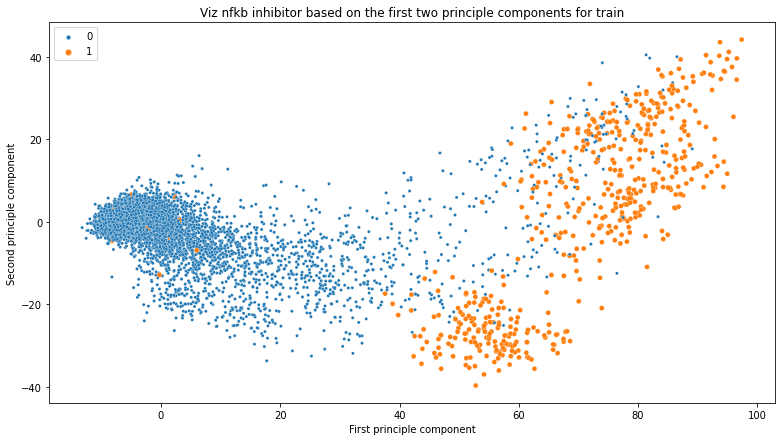

In [33]:
# Viz train based on target

plt.figure(figsize=(13,7))
sns.scatterplot(x=train_pca.loc[:, 0], y=train_pca.loc[:, 1], 
                hue=train_pca['nfkb_inhibitor'], 
                size=train_pca['nfkb_inhibitor'],
                sizes=(25, 10))

plt.title('Viz nfkb inhibitor based on the first two principle components for train')
plt.xlabel('First principle component')
plt.ylabel('Second principle component')
plt.legend()
plt.show()

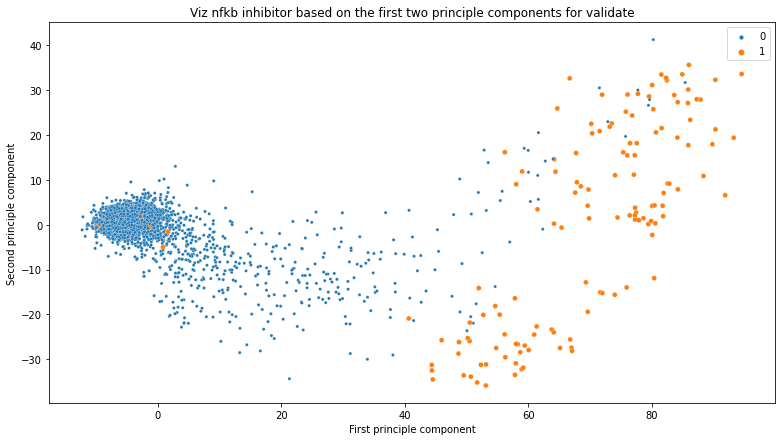

In [34]:
# Viz validate based on target

plt.figure(figsize=(13,7))
sns.scatterplot(x=validate_pca.loc[:, 0], y=validate_pca.loc[:, 1], 
                hue=validate_pca['nfkb_inhibitor'], 
                size=validate_pca['nfkb_inhibitor'],
                sizes=(25, 10))

plt.title('Viz nfkb inhibitor based on the first two principle components for validate')
plt.xlabel('First principle component')
plt.ylabel('Second principle component')
plt.legend()
plt.show()

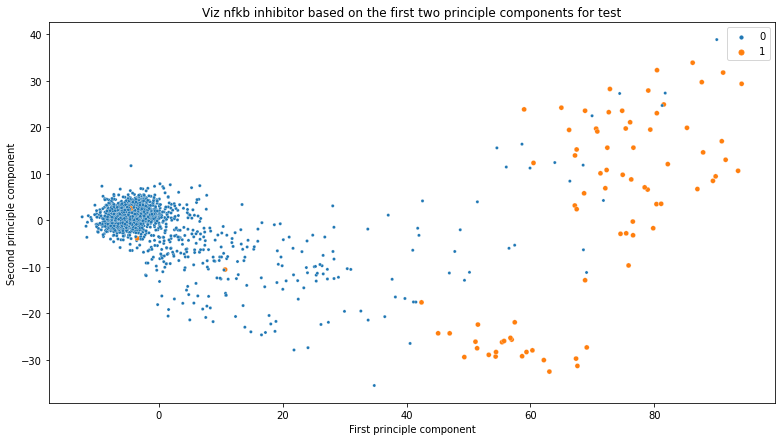

In [35]:
# Viz test based on target

plt.figure(figsize=(13,7))
sns.scatterplot(x=test_pca.loc[:, 0], y=test_pca.loc[:, 1], 
                hue=test_pca['nfkb_inhibitor'], 
                size=test_pca['nfkb_inhibitor'],
                sizes=(25, 10))

plt.title('Viz nfkb inhibitor based on the first two principle components for test')
plt.xlabel('First principle component')
plt.ylabel('Second principle component')
plt.legend()
plt.show()

**Takeaways**
- Visualiztion by the first two principle components reveals that the majority of the positives are seperated well from the negatives. 
- The original high dimentionality (more than 800 featurs) can be reduced to 10 PCA feaures and the f1-score remains above 0.9. 